# Benchmarks

## Initialize

In [1]:
#library(Rmisc)
library(dtplyr)
library(tidyverse)
library(glue)
library(arrow)
library(patchwork)
library(data.table)
library("jsonlite")
library(ggthemes)

Warning message:
“package ‘tidyverse’ was built under R version 4.0.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘readr’ was built under R version 4.0.5”
Warning message:
“package ‘purrr’ was built under R version 4.0.3”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”
Warning message:
“package ‘forcats’ was built under R version 4.0.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘arrow’ was built under R version 4.0.3”

Attaching package: ‘arrow’


The following object is masked from ‘p

In [2]:
if (grepl("sc", Sys.info()[["nodename"]], fixed=TRUE)) {
    base_path = "/sc-projects/sc-proj-ukb-cvd"
} else {
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"}
print(base_path)

project_label="22_medical_records"
project_path = glue("{base_path}/results/projects/{project_label}")
figure_path = glue("{project_path}/figures")
output_path = glue("{project_path}/data")

experiment = 220413
experiment_path = glue("{output_path}/{experiment}")

[1] "/sc-projects/sc-proj-ukb-cvd"


In [3]:
library(arrow)

In [30]:
endpoints_md = fread(glue("{experiment_path}/endpoints.csv"))
endpoints = sort(endpoints_md$endpoint)

In [39]:
endpoint_selection = c(
    "phecode_008",
    "phecode_092-2",
    "phecode_105",
    "phecode_107-2",
    "phecode_164",
    "phecode_202-2",
    "phecode_284",
    "phecode_292",
    "phecode_324-11",
    "phecode_328",
    "phecode_371",
    "phecode_401",
    "phecode_404",
    "phecode_424",
    "phecode_440-11",
    "phecode_468",
    "phecode_474",
    "phecode_522-1",
    "phecode_542-1",
    "phecode_581-1",
    "phecode_583",
    "phecode_665",
    "phecode_705-1",
    "OMOP_4306655"  
    )

In [40]:
endpoint_defs = arrow::read_feather(glue("{output_path}/phecode_defs_220306.feather")) %>% arrange(endpoint)

In [67]:
endpoint_defs = endpoint_defs %>% 
    mutate(name = phecode_string) %>% 
    mutate(name = 
           case_when( 
               endpoint == "phecode_008"~"H. pylori", 
               endpoint == "phecode_092-2"~"Sepsis", 
               endpoint == "phecode_105"~"Breast cancer", 
                endpoint == "phecode_107-2"~"Prostate cancer", 
               endpoint == "phecode_123"~"Malignant plasma cell neoplasms", 
               endpoint == "phecode_164"~"Anemia", 
               endpoint == "phecode_200-1"~"Hypothyroidism", 
               endpoint == "phecode_232"~"Vitamin deficiencies", 
               endpoint == "phecode_284"~"Suicide attempt or self harm", 
               #endpoint == "phecode_287-5"~"Drug-induced psychosis", 
               endpoint == "phecode_324-11"~"Parkinson's",
               endpoint == "phecode_328"~"Dementia", 
               #endpoint == "phecode_404"~"Coronary heart disease", 
               endpoint == "phecode_424"~"Heart failure", 
               endpoint == "phecode_440-11"~"Deep vein thrombosis", 
               endpoint == "phecode_468"~"Pneumonia", 
               endpoint == "phecode_474"~"COPD", 
               endpoint == "phecode_518"~"Appendicitis", 
               endpoint == "phecode_542-1"~"Fibrosis and cirrhosis of liver", 
               endpoint == "phecode_583"~"Chronic kidney disease", 
               endpoint == "phecode_705-1"~"Rheumatoid arthritis", 
               endpoint == "phecode_908-1"~"(Pre)eclampsia", 
               #endpoint == "phecode_976"~"Complication of anesthesia",
               TRUE ~ name)
           )

endpoint_map = endpoint_defs$name
names(endpoint_map) =  endpoint_defs$endpoint
endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint

In [42]:
eligable_eids = arrow::read_feather(glue("{output_path}/eligable_eids_long_220414.feather")) %>% 
    filter(endpoint %in% endpoint_selection) %>% 
    mutate(endpoint = as.character(endpoint)) %>%
    mutate(eid = as.numeric(as.character(eid))) %>%
    mutate(included = 1)

Warning message:
“Coercing dictionary values to R character factor levels”


In [43]:
data_outcomes = arrow::read_feather(glue("{output_path}/baseline_outcomes_long_220412.feather", as_data_frame=FALSE)) %>% 
    filter(endpoint %in% endpoint_selection) %>% left_join(eligable_eids, by=c("eid", "endpoint"))

In [44]:
partitions = 0:21

In [45]:
paths = c()
for (p in partitions){
    temp_path = glue("{experiment_path}/loghs/Identity(Records)+MLP/{p}/test.feather")
    paths = c(paths, temp_path)
    }

In [46]:
predictions = paths %>% map_df(
    ~suppressWarnings(read_feather(., col_select=c("eid", all_of(endpoint_selection)))) %>% 
    pivot_longer(endpoint_selection, names_to="endpoint", values_to="logh") %>%
    mutate(eid = as.integer(as.character(eid))) %>%
    select(endpoint, eid, logh))# %>% arrange(endpoint, eid)
predictions %>% head()

endpoint,eid,logh
<chr>,<int>,<dbl>
phecode_008,1475839,-2.1815271
phecode_092-2,1475839,-1.9031086
phecode_105,1475839,0.7244859
phecode_107-2,1475839,-4.2044363
phecode_164,1475839,-1.1667072
phecode_202-2,1475839,-1.8379885


In [47]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2)))

# Figure 2: Selected Endpoints

## Endpoint Prevalence

In [107]:
endpoints_md %>% filter(endpoint %in% endpoint_selection) %>% as_tibble() %>% arrange(n)  %>%
    mutate(endpoint = recode(endpoint, !!!endpoint_map)) %>% mutate(perc = freq*100)

V1,endpoint,n,freq,perc
<int>,<chr>,<int>,<dbl>,<dbl>
400,Somatoform disorders,632,0.001262765,0.1262765
1072,Fibrosis and cirrhosis of liver,1099,0.002188301,0.2188301
1107,Pyelonephritis,2347,0.004687924,0.4687924
1021,Inflammatory bowel disease,3019,0.006064892,0.6064892
11,H. pylori,3253,0.006529375,0.6529375
1360,Rheumatoid arthritis,3621,0.007257357,0.7257357
376,Suicide attempt or self harm,4128,0.008265886,0.8265886
428,Parkinson's,4196,0.008363531,0.8363531
58,Sepsis,4397,0.008766089,0.8766089


In [108]:
logh_inc = pred_outcomes %>% filter(included==1) %>% group_by(endpoint) %>% mutate(logh_perc = ntile(logh, 10)) %>% ungroup() %>% as_tibble()

In [109]:
logh_T_agg = logh_inc %>% group_by(endpoint, logh_perc) %>% summarise(n=sum(event), ratio = mean(event)) %>% as_tibble()

`summarise()` has grouped output by 'endpoint'. You can override using the `.groups` argument.



In [110]:
temp = logh_T_agg %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% 
    filter(endpoint %in% endpoint_selection) %>% ungroup() #%>% sample_n(10000)
temp %>% filter(logh_perc %in% c(1, 10)) %>% 
    pivot_wider(names_from=logh_perc, values_from=c(n, ratio)) %>% 
    mutate(ratio=ratio_10/ratio_1) %>%
    mutate(endpoint = recode(endpoint, !!!endpoint_map)) %>%
    #mutate(ratio_1=ratio_1*100, ratio_10 = ratio_10*100) %>% 
    arrange(ratio)

endpoint,n_1,n_10,ratio_1,ratio_10,ratio
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
Prostate cancer,727,2436,3.219236e-02,0.107873528,3.350905
Hypertension,3892,20439,9.588805e-02,0.503572484,5.251671
Parkinson's,79,1086,1.574615e-03,0.021646402,13.747109
Pyelonephritis,25,785,4.993508e-04,0.015679930,31.400627
H. pylori,17,852,3.412216e-04,0.017101222,50.117647
Dementia,54,2888,1.075012e-03,0.057494376,53.482546
Pneumonia,69,3854,1.400816e-03,0.078244275,55.856206
Psoriasis,32,1990,6.545574e-04,0.040706118,62.188772
Type 2 diabetes,138,10426,2.866639e-03,0.216581150,75.552294


## Metabolic state and incident disease

In [94]:
pred_outcomes = predictions %>% left_join(data_outcomes, on=c(eid, endpoint)) %>% as.data.table() 

Joining, by = c("endpoint", "eid")



In [95]:
logh_inc = pred_outcomes %>% filter(included==1) %>% group_by(endpoint) %>% mutate(logh_perc = ntile(logh, 100)) %>% ungroup() %>% as_tibble()

In [96]:
logh_T_agg = logh_inc %>% group_by(endpoint, logh_perc) %>% summarise(n=sum(event), ratio = mean(event)) %>% as_tibble()

`summarise()` has grouped output by 'endpoint'. You can override using the `.groups` argument.



In [97]:
#logh_T_endpoint = logh_inc %>% group_by(endpoint) %>% summarise(n_all=sum(event), ratio_all = mean(event)) %>% as_tibble()

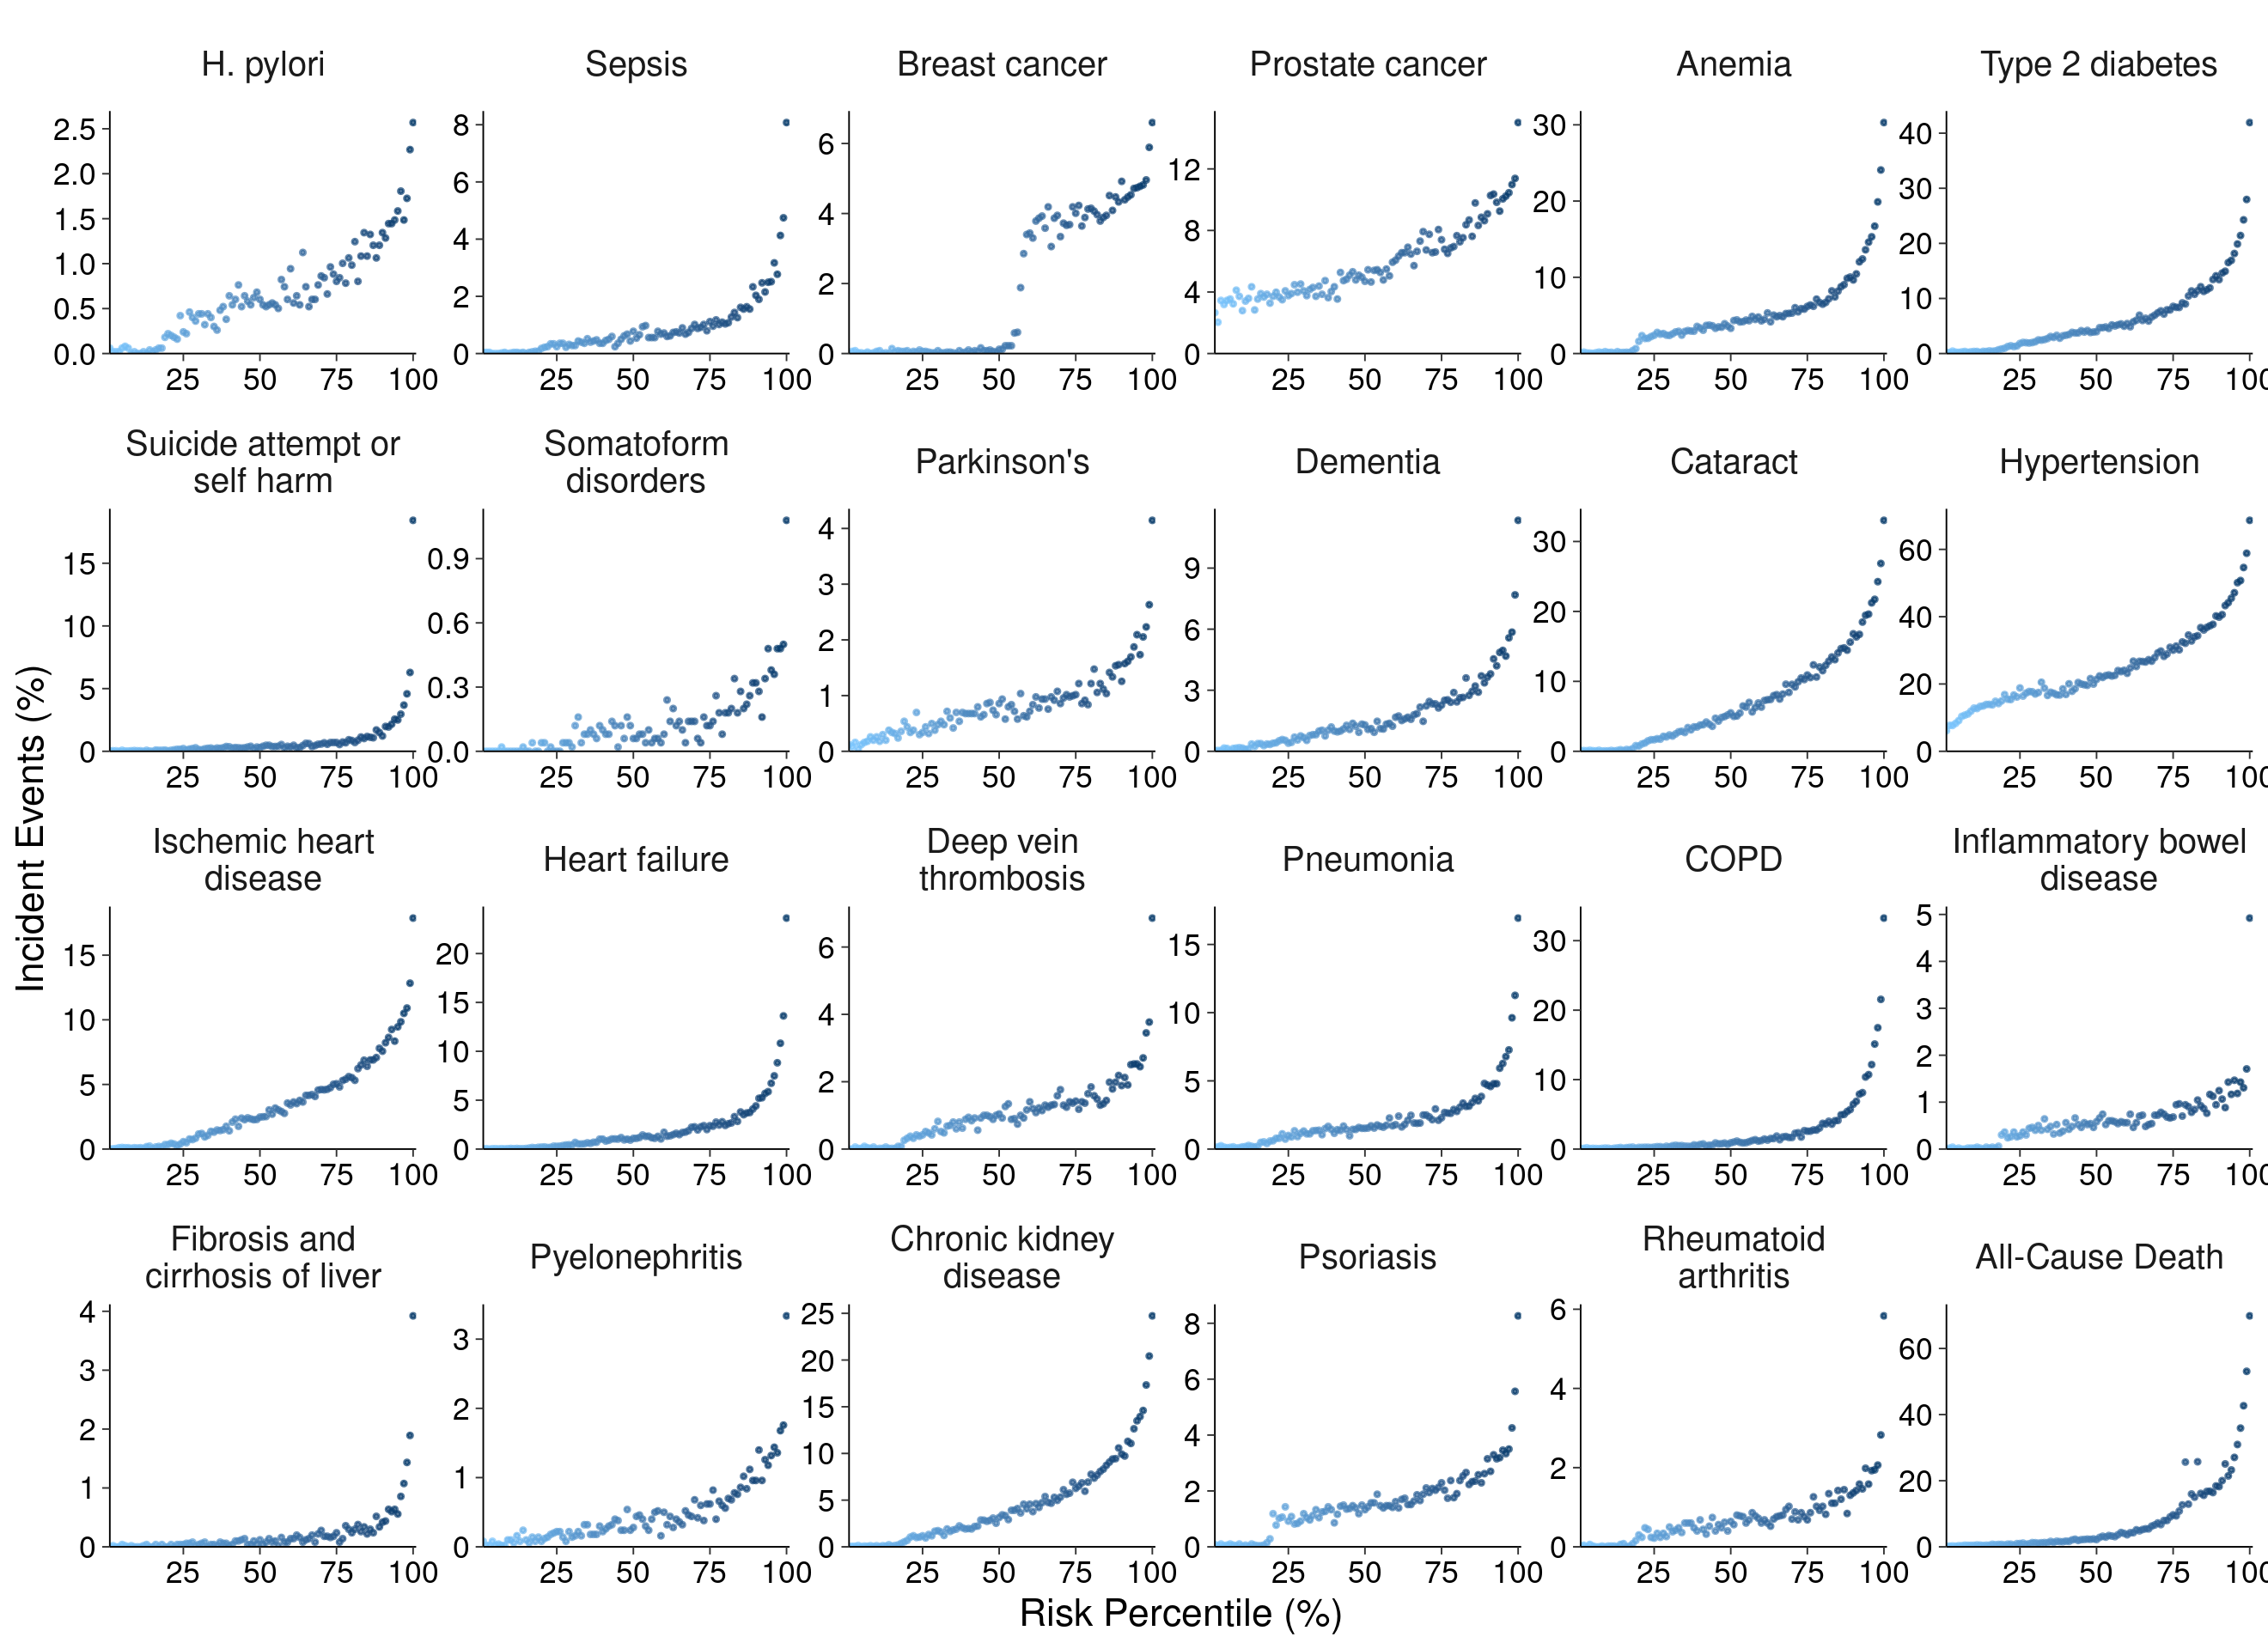

In [103]:
plot_width = 8.25; plot_height=6; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
#temp_rank = event_rest %>% filter(features=="Metabolomics") %>% arrange(desc(MET10PercvsREST))
endpoint_order = (endpoint_defs %>% mutate(phecode_rank = as.numeric(phecode)) %>% arrange(phecode_rank) %>% as_tibble())$endpoint
temp = logh_T_agg %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% filter(endpoint %in% endpoint_selection) %>% ungroup() #%>% sample_n(10000)

fig2a = ggplot(temp, aes(x=logh_perc, y=ratio*100, color=logh_perc)) + 
    labs(title=NULL, x="Risk Percentile (%)", y="Incident Events (%)") +
    geom_point(alpha=0.7, size=0.3) + 
    scale_colour_gradient(low = "#7AC6FF", high = "#023768", space = "Lab", na.value = "grey50", guide = "colourbar", aesthetics = "colour")+
    scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0, .05)))+#, limits=c(0, NA))+
    scale_x_continuous(expand=expansion(add=c(0, 1)))+
    facet_wrap(~endpoint, scale="free", labeller = labeller(endpoint = as_labeller(endpoint_map, default=label_wrap_gen(20))), ncol=6) + theme(legend.position="none")
fig2a

## Promille

In [23]:
logh_inc = pred_outcomes %>% filter(included==1) %>% group_by(endpoint) %>% mutate(logh_perc = ntile(logh, 1000)) %>% ungroup() %>% as_tibble()

In [24]:
logh_T_agg = logh_inc %>% group_by(endpoint, logh_perc) %>% summarise(n=sum(event), ratio = mean(event)) %>% as_tibble()

`summarise()` has grouped output by 'endpoint'. You can override using the `.groups` argument.



In [25]:
logh_T_endpoint = logh_inc %>% group_by(endpoint) %>% summarise(n_all=sum(event), ratio_all = mean(event)) %>% as_tibble()
logh_T_endpoint

endpoint,n_all,ratio_all
<chr>,<int>,<dbl>
phecode_092-2,4397,0.008766089
phecode_105,9100,0.018416952
phecode_107-2,13126,0.058125426
phecode_164,24201,0.050355491
phecode_284,4128,0.008265886
phecode_328,8705,0.017329798
phecode_371,34946,0.070569609
phecode_404,16554,0.033873889
phecode_424,10142,0.020252689


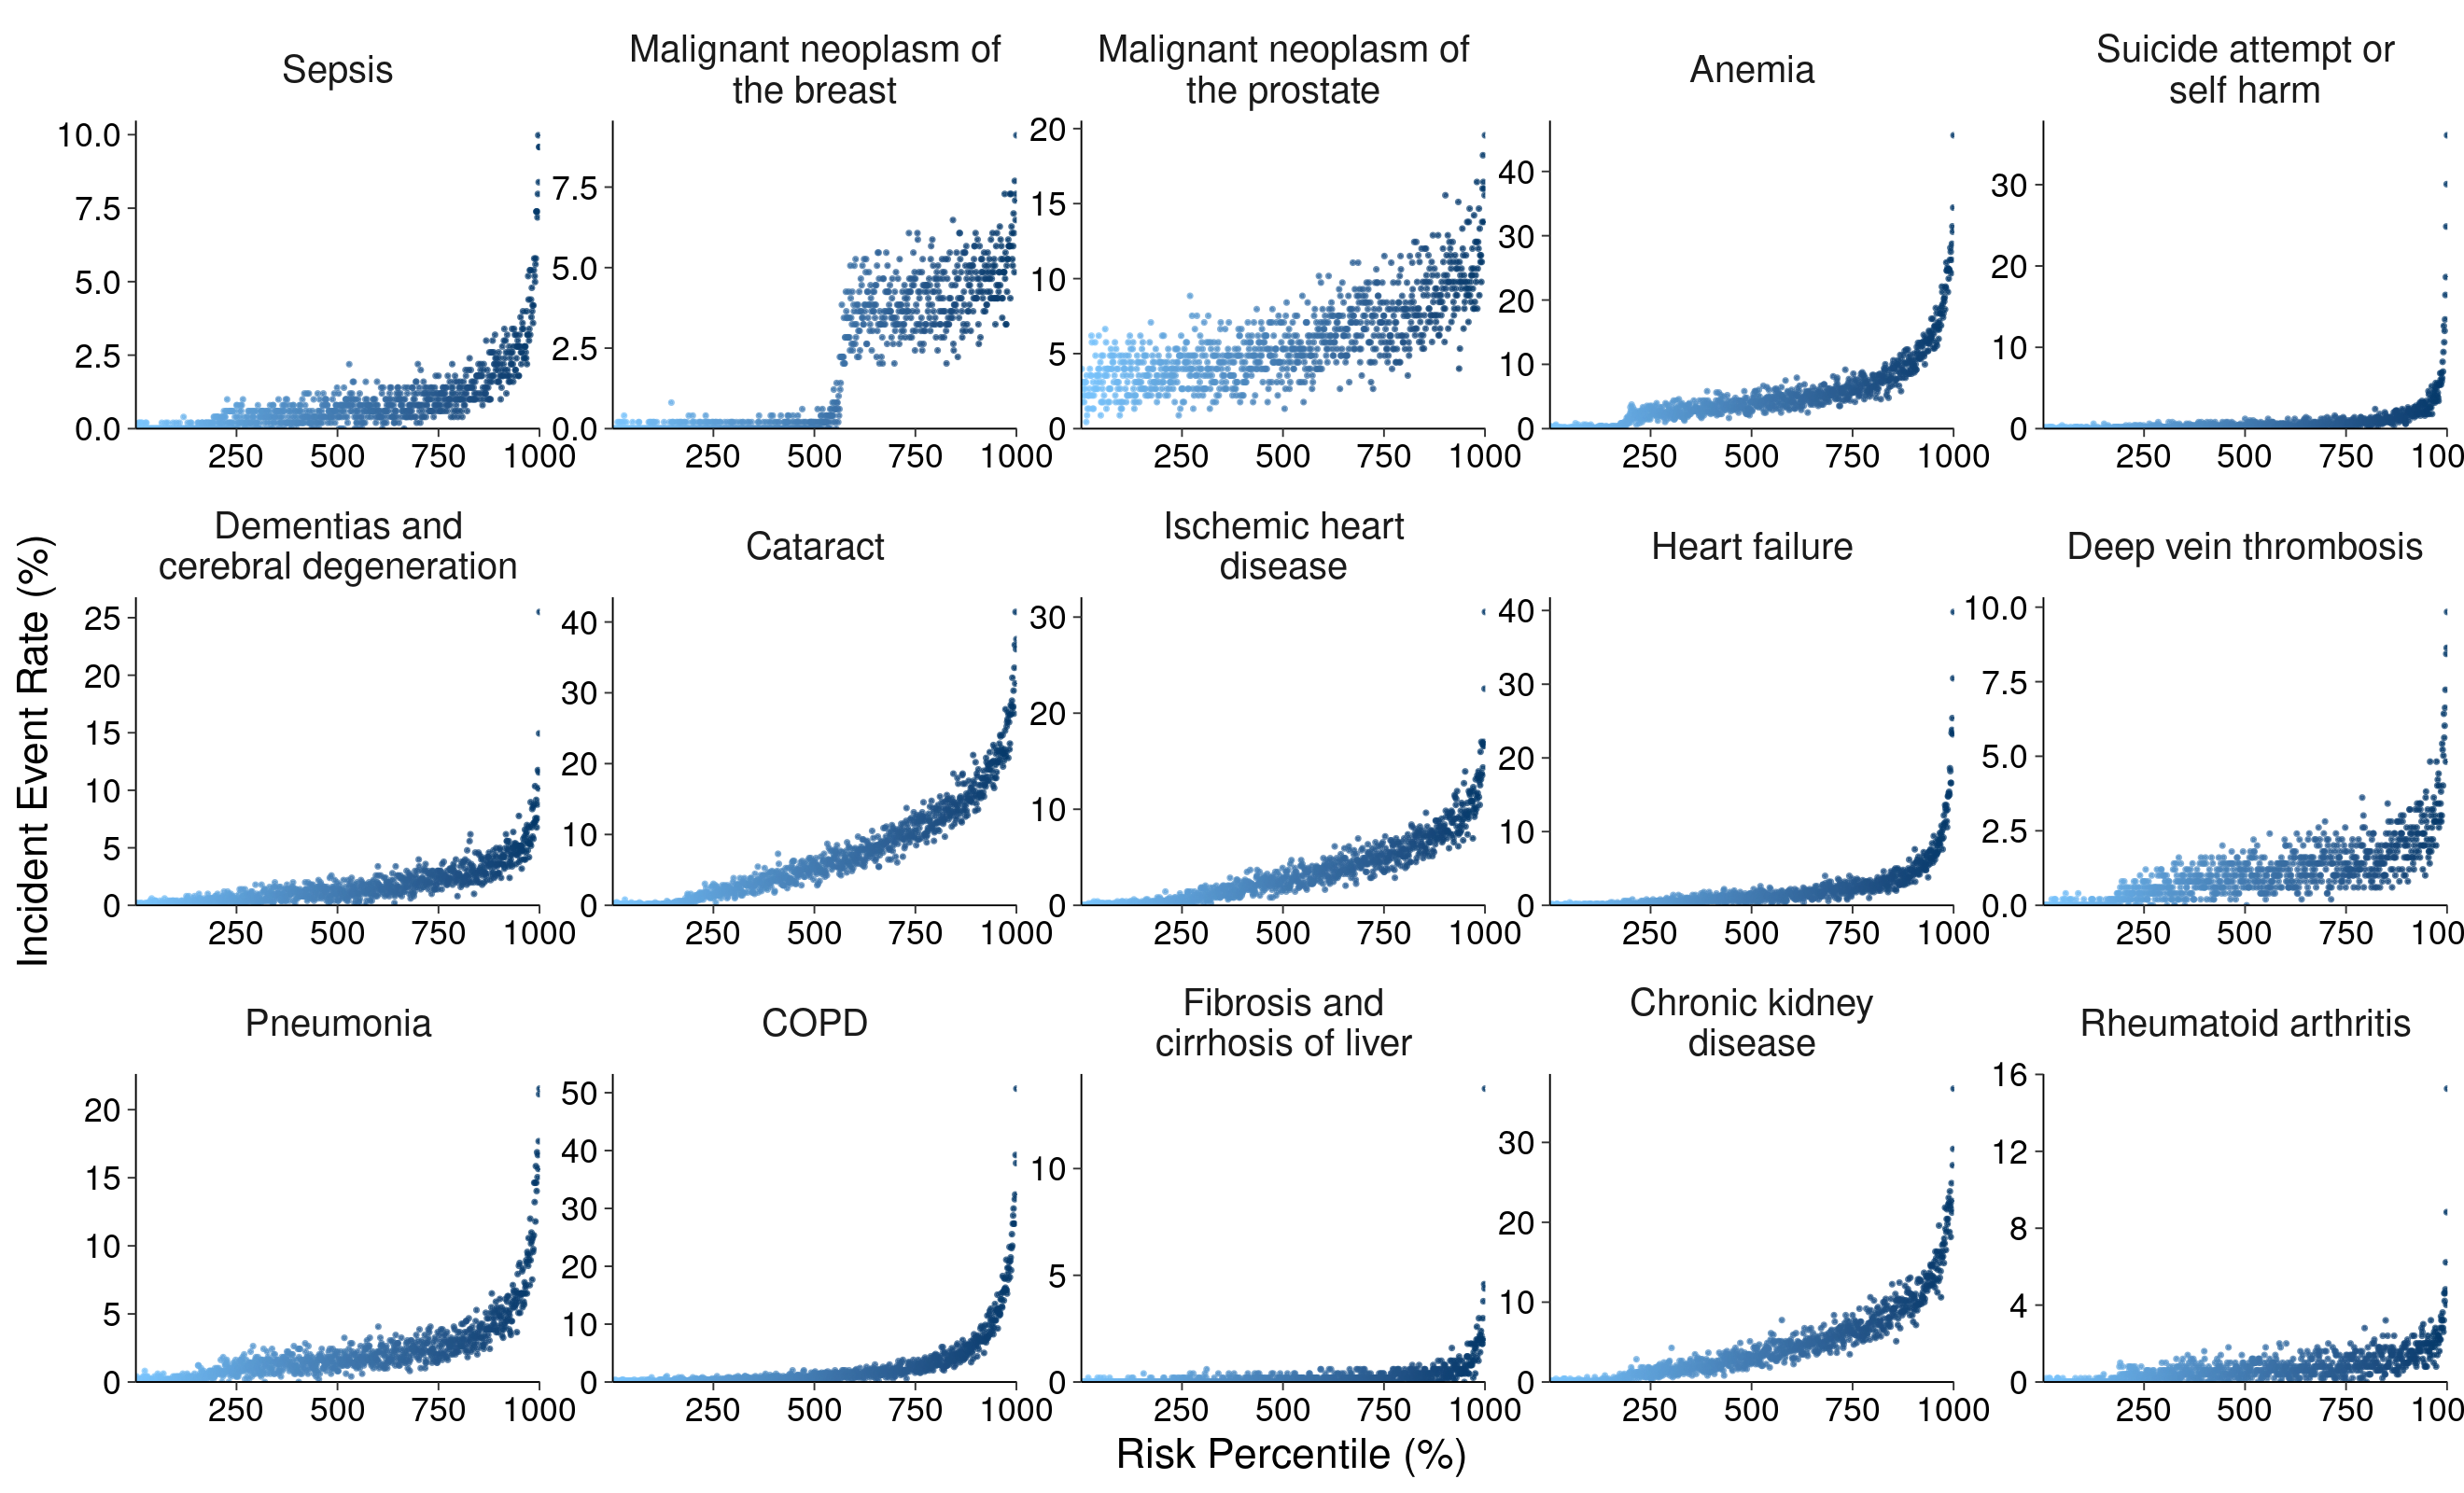

In [26]:
plot_width = 8.25; plot_height=5; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
#temp_rank = event_rest %>% filter(features=="Metabolomics") %>% arrange(desc(MET10PercvsREST))
endpoint_order = (endpoint_defs %>% mutate(phecode_rank = as.numeric(phecode)) %>% arrange(phecode_rank) %>% as_tibble())$endpoint
temp = logh_T_agg %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% filter(endpoint %in% endpoint_selection) %>% ungroup() #%>% sample_n(10000)

fig2a = ggplot(temp, aes(x=logh_perc, y=ratio*100, color=logh_perc)) + 
    labs(title=NULL, x="Risk Percentile (%)", y="Incident Event Rate (%)") +
    geom_point(alpha=0.7, size=0.1) + 
    scale_colour_gradient(low = "#7AC6FF", high = "#023768", space = "Lab", na.value = "grey50", guide = "colourbar", aesthetics = "colour")+
    scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0, .05)))+#, limits=c(0, NA))+
    scale_x_continuous(expand=expansion(add=c(0, 1)))+
    facet_wrap(~endpoint, scale="free", labeller = labeller(endpoint = as_labeller(endpoint_map, default=label_wrap_gen(22))), ncol=5) + theme(legend.position="none")
fig2a

In [26]:
temp %>% group_by(endpoint) %>% filter(n_ratio>0.25) %>% slice_min(1)

ERROR: Error: Problem with `filter()` input `..1`.
[34mℹ[39m Input `..1` is `n_ratio > 0.25`.
[31m✖[39m object 'n_ratio' not found
[34mℹ[39m The error occurred in group 1: endpoint = phecode_092-2.


# Kaplan Mayer

In [104]:
logh_mh = logh_inc %>% select(endpoint, eid, logh_perc, event, time) %>% group_by(endpoint) %>% 
    mutate(MH=case_when(logh_perc %in% 100 ~ "High", 
                        logh_perc %in% 51 ~ "Mid", 
                        logh_perc %in% 1 ~ "Low",
                        TRUE ~ "NA")
          ) %>% mutate(MH=fct_rev(factor(MH, levels=c("Low", "Mid", "High")))) %>% ungroup() %>% 
    filter(MH!="NA") #%>% select(eid, endpoint, logh, logh_group)

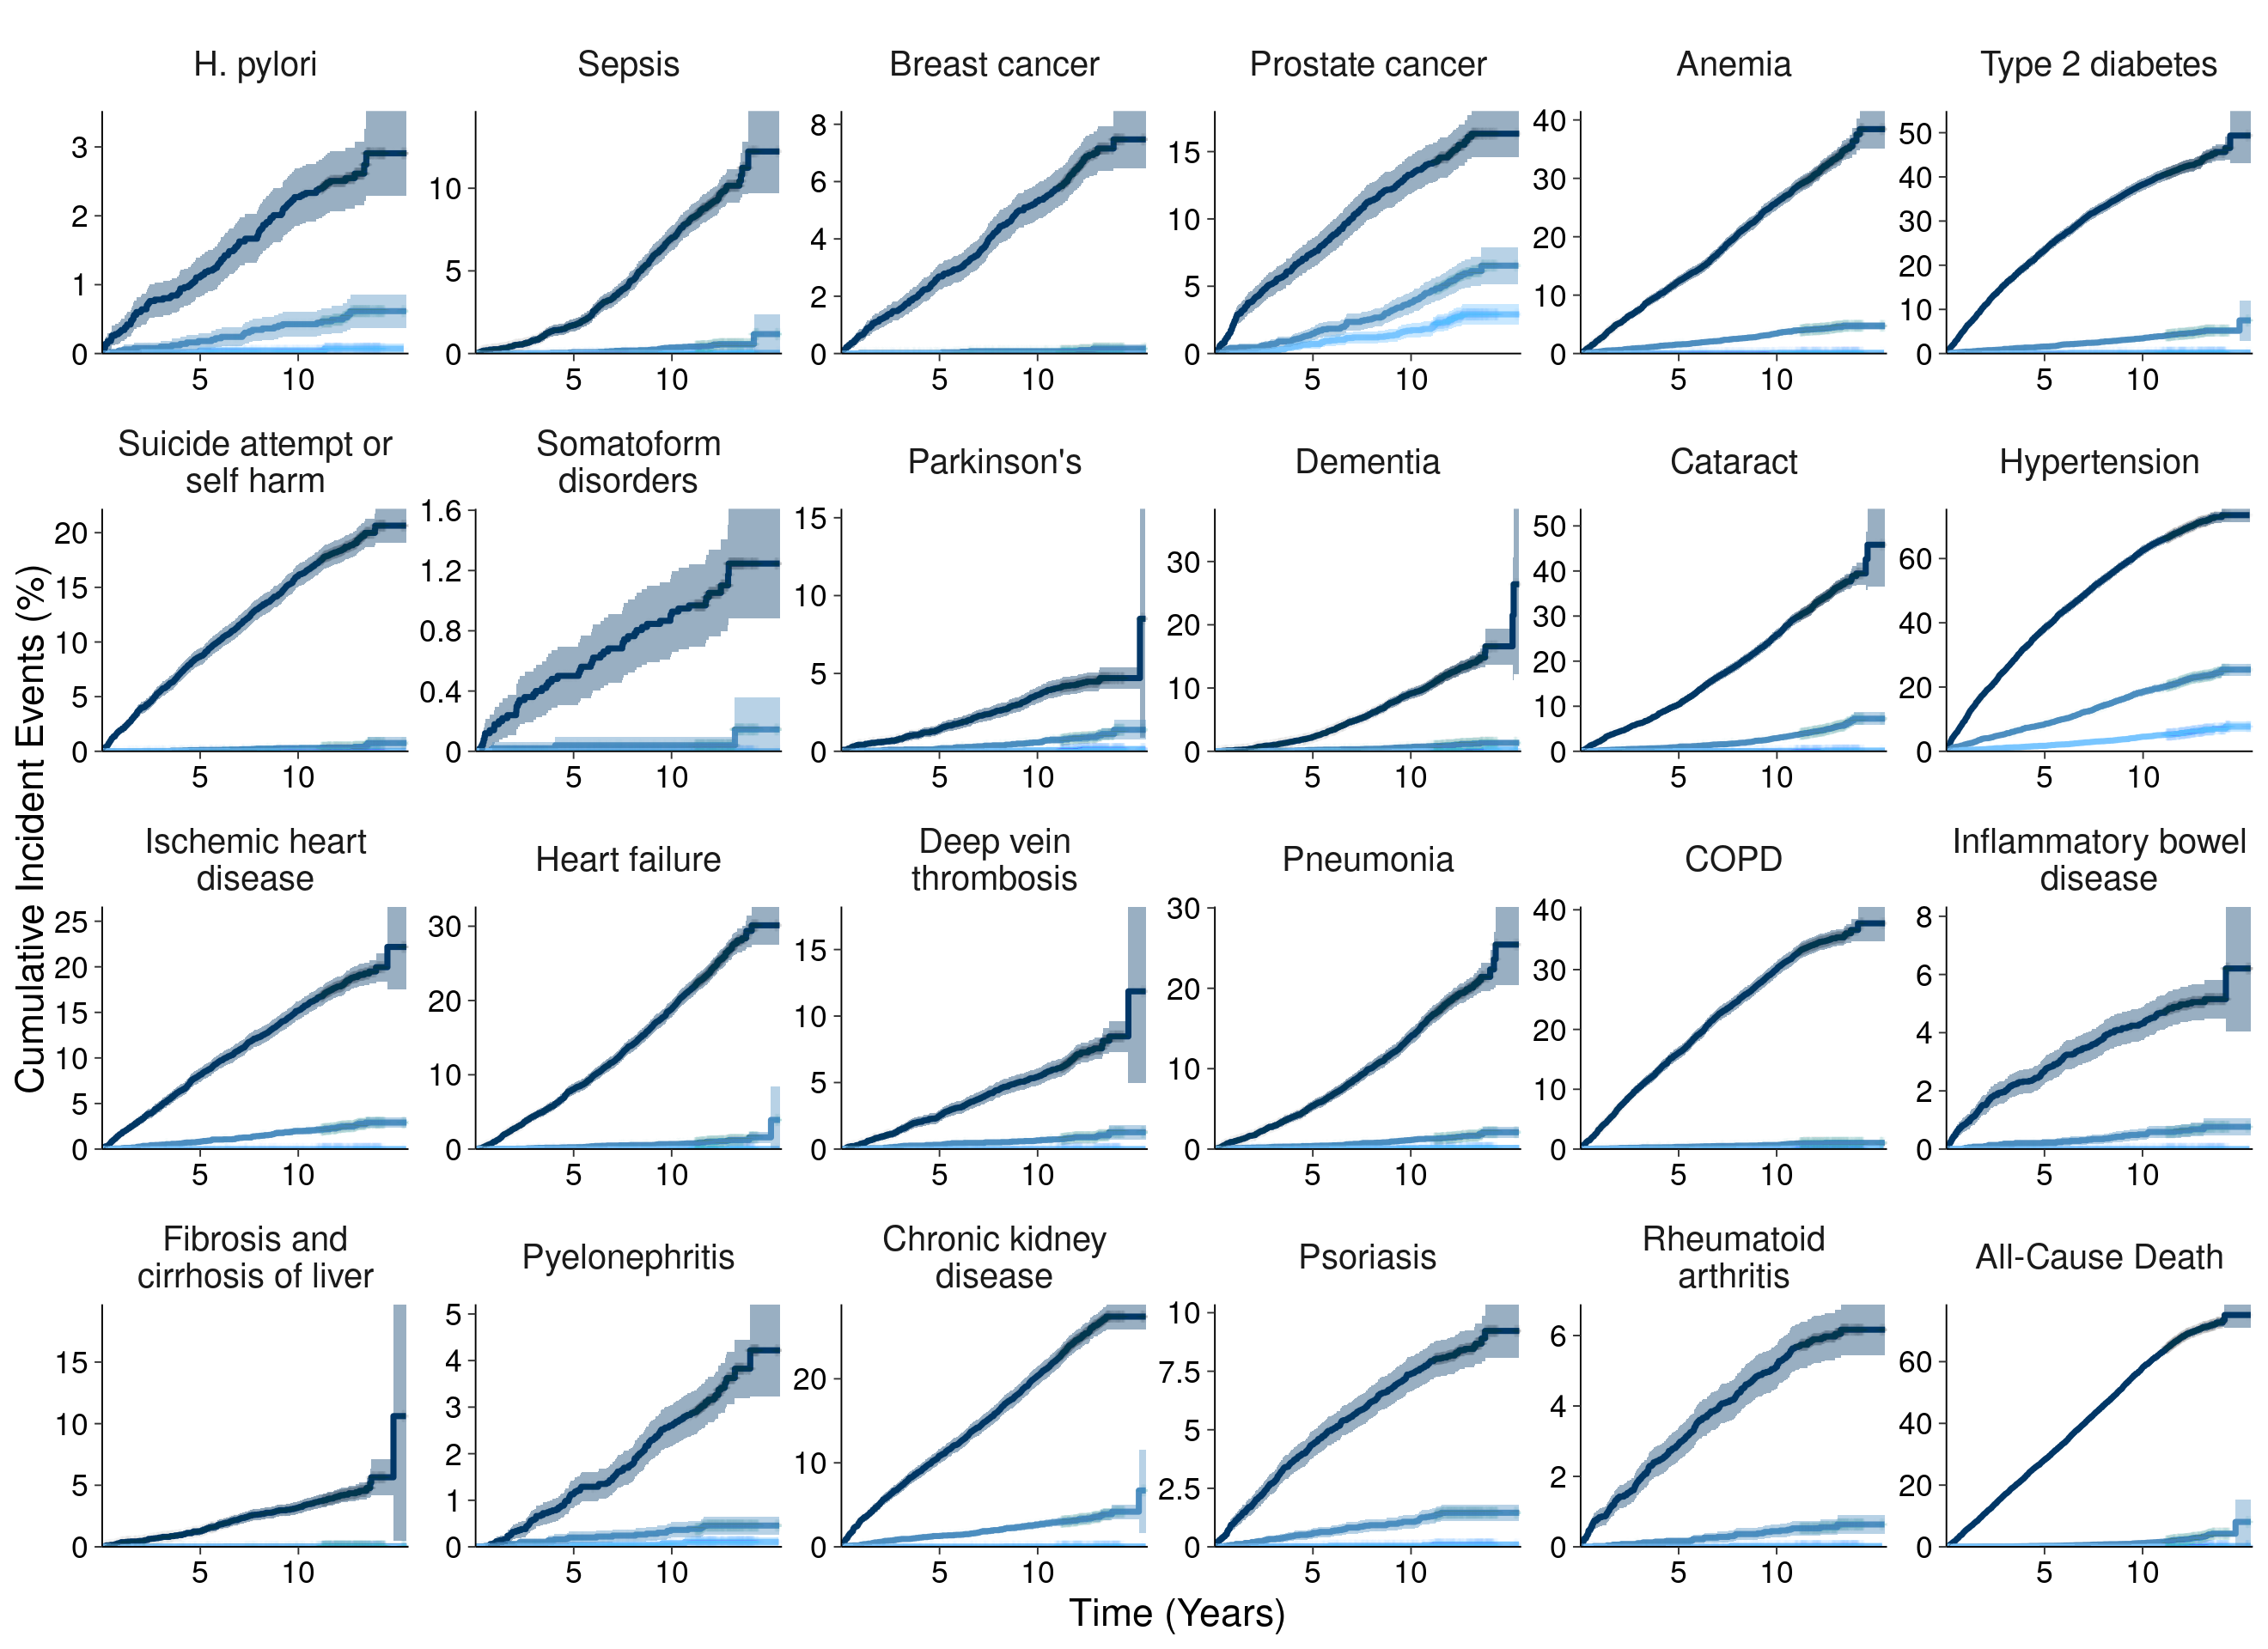

In [99]:
require("ggquickeda")
plot_width = 8.25; plot_height=6; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
met_map = c("High"="#023768", "Mid"="#4F8EC1", "Low"="#7AC6FF")

temp = logh_mh %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% filter(endpoint %in% endpoint_selection) %>% ungroup() 

fig2b = ggplot(temp, aes(time = time, status = event, fill=MH, color=MH, group=MH)) +
    geom_km(trans = "event") + 
    geom_kmticks(trans = "event", size=0.2, alpha=0.01) + 
    geom_kmband(trans = "event") + 
    labs(x="Time (Years)", y="Cumulative Incident Events (%)")+
    scale_color_manual(values=met_map)+scale_fill_manual(values=met_map)+
    scale_y_continuous(labels = function(x) round(x*100, 1), expand=c(0, 0))+
    scale_x_continuous(expand=expansion(add=c(0, .1)), breaks=c(5, 10))+
    facet_wrap(~endpoint, scale="free", labeller = labeller(endpoint = as_labeller(endpoint_map, default=label_wrap_gen(20))), ncol=6) + theme(legend.position="none")
fig2b

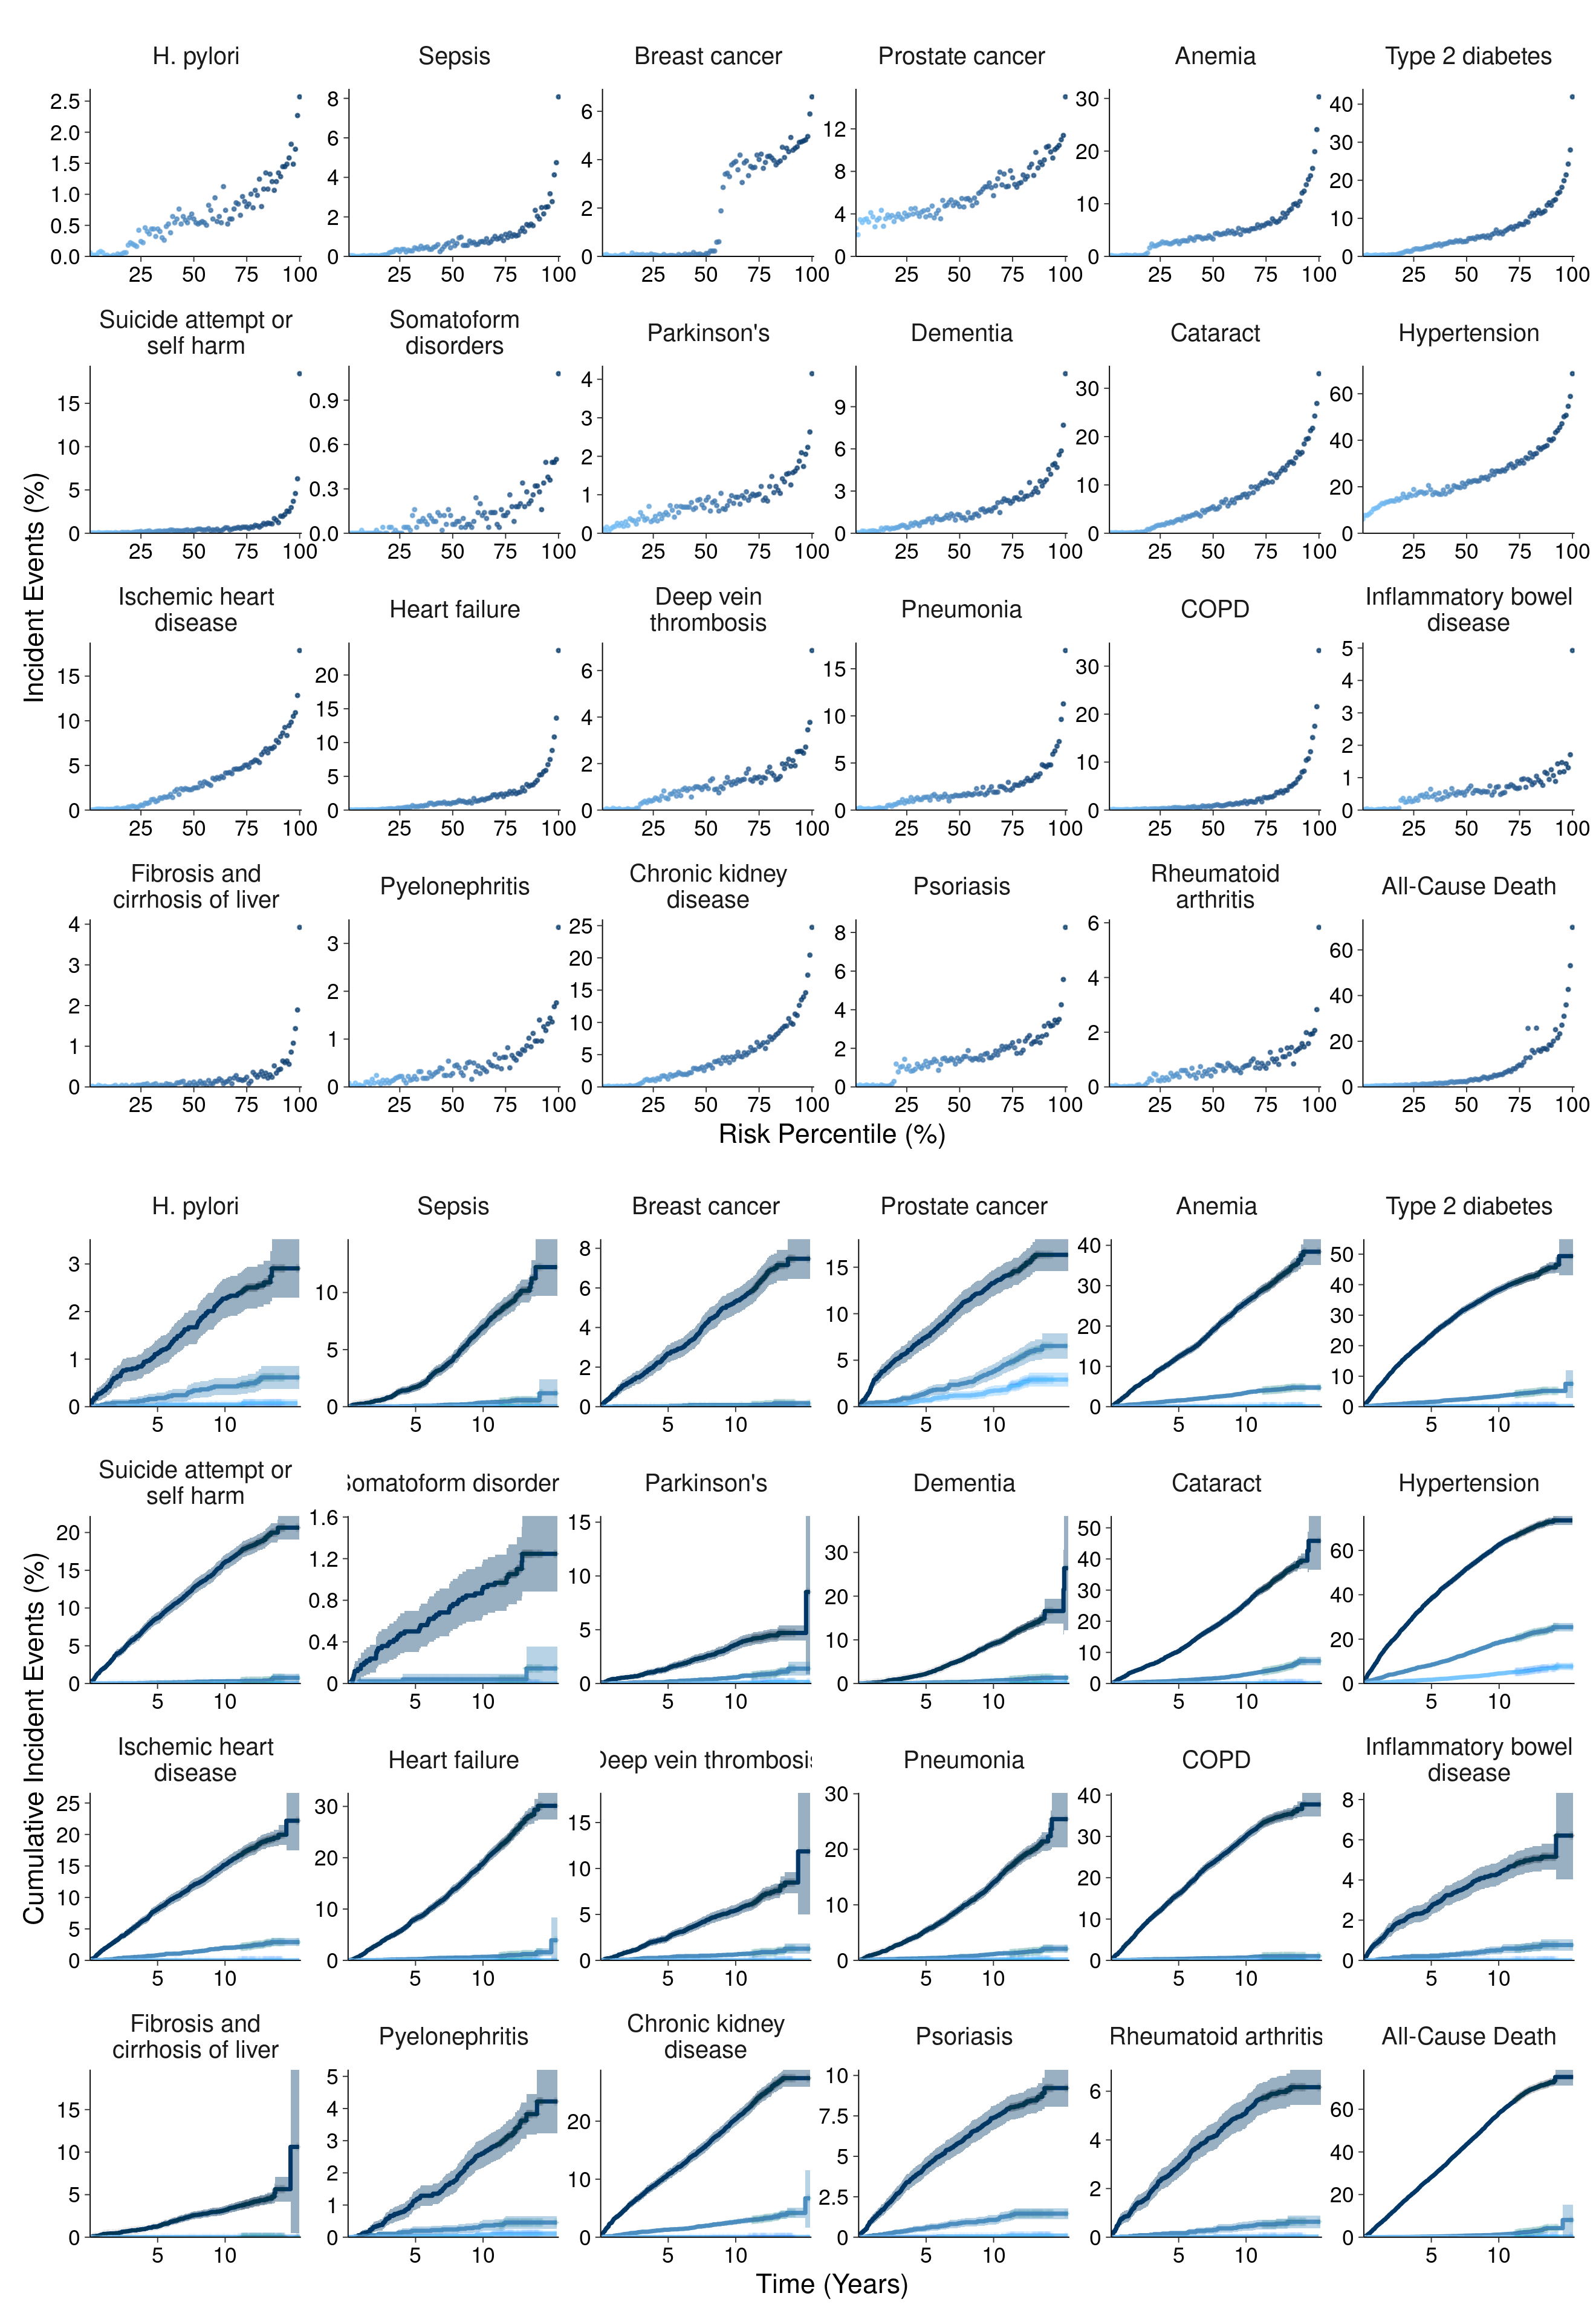

In [105]:
plot_width = 8.25; plot_height=12; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

fig2 = (fig2a / fig2b)
fig2

In [55]:
plot_name = "Figure_2_EventRates"
fig2 %>% ggsave(filename=glue("outputs/{plot_name}.pdf"), device="pdf", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

In [17]:
plot_width = 50; plot_height=75; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
#temp_rank = event_rest %>% filter(features=="Metabolomics") %>% arrange(desc(MET10PercvsREST))
endpoint_order = (phecode_defs %>% mutate(phecode_rank = as.numeric(phecode)) %>% arrange(phecode_rank) %>% as_tibble())$endpoint
endpoint_selection = endpoint_order# %>% head(500)
temp = logh_T_agg %>% filter(model=="GNN(Records)+MLP") %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% filter(endpoint %in% endpoint_selection) %>% ungroup() #%>% sample_n(10000)

mh_events = ggplot(temp, aes(x=logh_perc, y=ratio*100, color=logh_perc)) + 
    labs(title=NULL, x="Medical History Percentile [%]", y="Observed Event Rate [%]") +
    geom_point(alpha=0.7, size=0.1) + 
    scale_colour_gradient(
  low = "#7AC6FF",
  high = "#023768",
  space = "Lab",
  na.value = "grey50",
  guide = "colourbar",
  aesthetics = "colour"
)+
    #scale_color_manual(values=c("Metabolomics"="black"))+
    scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0, .05)))+#, limits=c(0, NA))+
    scale_x_continuous(expand=expansion(add=c(0, 1)))+
    facet_wrap(~endpoint, scale="free", labeller = labeller(endpoint = endpoint_map), ncol=25) + theme(legend.position="none")

In [19]:
plot_name = "MedicalHistoryRisk"
mh_events %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

## Add buffer

In [14]:
pred_outcomes %>% head()

eid,partition,model,endpoint,logh,prevalent,event,time
<int>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1475839,0,Identity(Records)+MLP,OMOP_4306655,-2.819316,0,0,12.564256
1475840,0,Identity(Records)+MLP,OMOP_4306655,-2.011223,0,1,6.817248
1475853,0,Identity(Records)+MLP,OMOP_4306655,-2.831062,0,0,12.772336
1475862,0,Identity(Records)+MLP,OMOP_4306655,-2.578309,0,0,11.660746
1475871,0,Identity(Records)+MLP,OMOP_4306655,-3.008898,0,0,11.879779
1475886,0,Identity(Records)+MLP,OMOP_4306655,-3.047699,0,0,12.646393


In [15]:
logh_T_agg_buffer = pred_outcomes %>% filter(prevalent==0) %>% mutate(event_buffer = case_when((event!=0&time<1) ~ 0, TRUE ~ event)) %>% group_by(endpoint, model) %>% mutate(logh_perc = ntile(logh, 100)) %>% group_by(endpoint, model, logh_perc) %>% summarise(ratio = mean(event_buffer)) %>% as_tibble()

`summarise()` has grouped output by 'endpoint', 'model'. You can override using the `.groups` argument.



In [16]:
logh_T_agg_buffer %>% write_feather(glue("{output_path}/logh_agg_1ybuffer_220224.feather"))

In [17]:
plot_width = 50; plot_height=75; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
#temp_rank = event_rest %>% filter(features=="Metabolomics") %>% arrange(desc(MET10PercvsREST))
endpoint_order = (phecode_defs %>% mutate(phecode_rank = as.numeric(phecode)) %>% arrange(phecode_rank) %>% as_tibble())$endpoint
endpoint_selection = endpoint_order# %>% head(500)
temp = logh_T_agg_buffer %>% filter(model=="GNN(Records)+MLP") %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% filter(endpoint %in% endpoint_selection) %>% ungroup() #%>% sample_n(10000)

mh_events = ggplot(temp, aes(x=logh_perc, y=ratio*100, color=logh_perc)) + 
    labs(title=NULL, x="Medical History Percentile [%]", y="Observed Event Rate [%]") +
    geom_point(alpha=0.7, size=0.1) + 
    scale_colour_gradient(
  low = "#7AC6FF",
  high = "#023768",
  space = "Lab",
  na.value = "grey50",
  guide = "colourbar",
  aesthetics = "colour"
)+
    #scale_color_manual(values=c("Metabolomics"="black"))+
    scale_y_continuous(limits=c(0, NA), expand=expansion(mult=c(0, .05)))+#, limits=c(0, NA))+
    scale_x_continuous(expand=expansion(add=c(0, 1)))+
    facet_wrap(~endpoint, scale="free", labeller = labeller(endpoint = endpoint_map), ncol=25) + theme(legend.position="none")

In [18]:
plot_name = "MedicalHistoryRisk_1ybuffer"
mh_events %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

## Metabolomic State and Event Trajectories

In [19]:
logh_mh = logh_inc %>% select(endpoint, model, eid, logh_perc, event, time) %>% group_by(endpoint) %>% 
    mutate(MH=case_when(logh_perc %in% 91:100 ~ "High", 
                        logh_perc %in% 45:55 ~ "Mid", 
                        logh_perc %in% 1:10 ~ "Low",
                        TRUE ~ "NA")
          ) %>% mutate(MET = fct_rev(factor(MET, levels=c("Low", "Mid", "High")))) %>% ungroup() %>% 
    filter(MH!="NA") #%>% select(eid, endpoint, logh, logh_group)

In [23]:
require("ggquickeda")
plot_width = 50; plot_height=75; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
met_map = c("High"="#023768", "Mid"="#4F8EC1", "Low"="#7AC6FF")

endpoint_order = (phecode_defs %>% mutate(phecode_rank = as.numeric(phecode)) %>% arrange(phecode_rank) %>% as_tibble())$endpoint
endpoint_selection = endpoint_order# %>% head(500)
temp = logh_mh %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% filter(endpoint %in% endpoint_selection) %>% ungroup() 

km_plot = ggplot(temp, aes(time = time, status = event, fill=MET, color=MET,group=MET)) +
    geom_km(trans = "event") + 
    geom_kmticks(trans = "event", size=0.3) + geom_kmband(trans = "event") + 
    labs(x="Time [Years]", y="Cumulative Events [%]")+
    scale_color_manual(values=met_map)+scale_fill_manual(values=met_map)+
    scale_y_continuous(labels = function(x) round(x*100, 1), expand=c(0, 0))+
    scale_x_continuous(expand=expansion(add=c(0, .1)), breaks=c(5, 10))+
    facet_wrap(~ endpoint, scale="free", labeller = labeller(endpoint = endpoint_map), ncol=25) + theme(legend.position="none")

In [ ]:
plot_name = "MedicalHistory_KMs"
km_plot %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

# Top 1%

In [26]:
logh_mh = logh_inc %>% select(endpoint, model, eid, logh_perc, event, time) %>% group_by(endpoint) %>% 
    mutate(MH=case_when(logh_perc == 100 ~ "High", 
                        logh_perc %in% 50:51 ~ "Mid", 
                        logh_perc == 1 ~ "Low",
                        TRUE ~ "NA")
          ) %>% mutate(MET = fct_rev(factor(MH, levels=c("Low", "Mid", "High")))) %>% ungroup() %>% 
    filter(MH!="NA") #%>% select(eid, endpoint, logh, logh_group)

In [27]:
require("ggquickeda")
plot_width = 50; plot_height=75; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
mh_map = c("High"="#023768", "Mid"="#4F8EC1", "Low"="#7AC6FF")

endpoint_order = (phecode_defs %>% mutate(phecode_rank = as.numeric(phecode)) %>% arrange(phecode_rank) %>% as_tibble())$endpoint
endpoint_selection = endpoint_order# %>% head(500)
temp = logh_mh %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% filter(endpoint %in% endpoint_selection) %>% ungroup() 

km_plot = ggplot(temp, aes(time = time, status = event, fill=MH, color=MH,group=MH)) +
    geom_km(trans = "event") + 
    geom_kmticks(trans = "event", size=0.3) + geom_kmband(trans = "event") + 
    labs(x="Time [Years]", y="Cumulative Events [%]")+
    scale_color_manual(values=met_map)+scale_fill_manual(values=mh_map)+
    scale_y_continuous(labels = function(x) round(x*100, 1), expand=c(0, 0))+
    scale_x_continuous(expand=expansion(add=c(0, .1)), breaks=c(5, 10))+
    facet_wrap(~ endpoint, scale="free", labeller = labeller(endpoint = endpoint_map), ncol=25) + theme(legend.position="none")

In [28]:
plot_name = "MedicalHistory_KMs_Top1"
km_plot %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

# Figure 2

In [ ]:
plot_width=8.25; plot_height=10; plot_dpi=320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_dpi)
fig2 = met_events / km_plot# +plot_annotation(tag_levels = 'A')

In [ ]:
fig2

In [ ]:
library(gt)
plot_name = "Figures_2_AB"
fig2 %>% ggsave(filename=glue("outputs/{plot_name}.pdf"), device="pdf", width=plot_width, height=plot_height, dpi=320)